In [1]:
import os
import numpy as np
import torch
from sklearn.metrics import (
    precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import seaborn as sns
import matplotlib.pyplot as plt
import time
import argparse
import importlib.util
from sklearn.preprocessing import label_binarize

# Function to load the model architecture from a given .py file
def load_model_class(model_py_path):
    spec = importlib.util.spec_from_file_location("EEGClassifier", model_py_path)
    model_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(model_module)
    return model_module.EEGClassifier

# Function to load the saved model
def load_model(model_path, model_class, device='cuda'):
    model = model_class()  # Initialize the model architecture (EEGClassifier in your case)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Function to load test data from .npy files
def load_test_data():
    test_data = np.load('data/test/data.npy')
    test_labels = np.load('data/test/labels.npy')
    return test_data, test_labels

# Batched inference to reduce memory usage, assuming model outputs probabilities
def batched_inference(model, test_data, batch_size=64, device='cuda'):
    outputs = []
    model.eval()

    for i in range(0, len(test_data), batch_size):
        batch_data = torch.tensor(test_data[i:i+batch_size]).float().to(device)
        with torch.no_grad():
            batch_output = model(batch_data).cpu().numpy()  # Move to CPU to free GPU memory
        outputs.append(batch_output)

    outputs = np.vstack(outputs)  # Combine batches into one array
    return outputs

# Function to evaluate metrics (precision, recall, F1 score, support, etc.)
def evaluate_metrics(test_labels, predictions, outputs, num_classes):
    precision = precision_score(test_labels, predictions, average='weighted')
    recall = recall_score(test_labels, predictions, average='weighted')
    f1 = f1_score(test_labels, predictions, average='weighted')
    kappa = cohen_kappa_score(test_labels, predictions)

    # Calculate AUC-ROC (multi-class)
    try:
        # One-hot encode the labels for multi-class ROC-AUC calculation
        test_labels_bin = label_binarize(test_labels, classes=list(range(num_classes)))
        auc_score = roc_auc_score(test_labels_bin, outputs, multi_class='ovo', average='weighted')
    except ValueError:
        auc_score = None
        print("AUC-ROC could not be calculated due to data formatting.")
    
    # Generate support for each class from classification report
    report_dict = classification_report(test_labels, predictions, output_dict=True)
    support = {label: metrics["support"] for label, metrics in report_dict.items() if label.isdigit()}

    return precision, recall, f1, kappa, auc_score, support

# Function to plot ROC curve for each class and save
def plot_roc_curve(test_labels, outputs, num_classes, model_name):
    test_labels_bin = label_binarize(test_labels, classes=list(range(num_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(8, 6))

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], outputs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    roc_filename = f"./output/models/{model_name}/{model_name}_roc_curve.png"
    plt.savefig(roc_filename)
    print(f"Saved ROC curve as {roc_filename}")
    plt.show()

# Function to plot Precision-Recall curve for each class and save
def plot_pr_curve(test_labels, outputs, num_classes, model_name):
    test_labels_bin = label_binarize(test_labels, classes=list(range(num_classes)))

    precision = dict()
    recall = dict()
    pr_auc = dict()

    plt.figure(figsize=(8, 6))

    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(test_labels_bin[:, i], outputs[:, i])
        pr_auc[i] = auc(recall[i], precision[i])
        plt.plot(recall[i], precision[i], label=f'Class {i} (AUC = {pr_auc[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    pr_filename = f"./output/models/{model_name}/{model_name}_pr_curve.png"
    plt.savefig(pr_filename)
    print(f"Saved Precision-Recall curve as {pr_filename}")
    plt.show()

# Confusion matrix and classification report
def generate_confusion_matrix(test_labels, predictions, model_name):
    conf_matrix = confusion_matrix(test_labels, predictions)
    report = classification_report(test_labels, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    conf_matrix_filename = f"./output/models/{model_name}/{model_name}_confusion_matrix.png"
    plt.savefig(conf_matrix_filename)
    print(f"Saved Confusion Matrix as {conf_matrix_filename}")
    plt.show()

    return conf_matrix, report

# Function to save evaluation metrics to a file
def save_results_to_file(precision, recall, f1, kappa, auc_score, support, conf_matrix, report, test_duration, model_name):
    file_name = f"./output/models/{model_name}/{model_name}_eval_result.txt"
    with open(file_name, "w") as f:
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n")
        f.write(f"Kappa: {kappa:.4f}\n")
        f.write(f"AUC: {auc_score:.4f}\n" if auc_score else "AUC: Not calculated\n")
        f.write(f"Test Duration: {test_duration:.4f} seconds\n")
        f.write(f"Support (number of true instances per class):\n")
        for label, count in support.items():
            f.write(f"Class {label}: {count} instances\n")
        f.write(f"Confusion Matrix:\n{conf_matrix}\n")
        f.write(f"Classification Report:\n{report}\n")
    print(f"Saved evaluation results as {file_name}")

# Main evaluation function
def evaluate_model_with_timing(model, test_data, test_labels, num_classes=6, batch_size=120, device='cuda', model_name="model"):
    # Start time for inference
    start_time = time.time()

    # Run batched inference
    outputs = batched_inference(model, test_data, batch_size=batch_size, device=device)

    # End time for inference
    end_time = time.time()
    test_duration = end_time - start_time

    # Predictions and ground truth
    predictions = np.argmax(outputs, axis=1)

    # Evaluate metrics (including support)
    precision, recall, f1, kappa, auc_score, support = evaluate_metrics(test_labels, predictions, outputs, num_classes)
    
    # Confusion matrix and classification report
    conf_matrix, report = generate_confusion_matrix(test_labels, predictions, model_name)

    # Plot ROC and PR curves
    plot_roc_curve(test_labels, outputs, num_classes, model_name)
    plot_pr_curve(test_labels, outputs, num_classes, model_name)

    return precision, recall, f1, kappa, auc_score, support, conf_matrix, report, test_duration

# # Main function to load model, test data, and evaluate
# def main():
def evalfun(model_py_path, model_pt_path):

    # parser = argparse.ArgumentParser(description="Evaluate a trained model on test data.")
    # parser.add_argument('model_path', type=str, help='Path to the .pt file of the trained model')
    # parser.add_argument('model_py_path', type=str, help='Path to the .py file of the model architecture')
    # args = parser.parse_args()

    # Extract model name from the .py file path (remove .py extension)
    # model_name = os.path.basename(args.model_py_path).replace('.py', '')
    model_name = os.path.basename(model_py_path).replace('.py', '')

    # Load model architecture from the provided .py file
    # model_class = load_model_class(args.model_py_path)
    model_class = load_model_class(model_py_path)

    # Load the model
    # model = load_model(args.model_path, model_class, device='cuda')
    model = load_model(model_pt_path, model_class, device='cuda')

    # Load test data
    test_data, test_labels = load_test_data()

    # Evaluate model and compute metrics with timing
    precision, recall, f1, kappa, auc_score, support, conf_matrix, report, test_duration = evaluate_model_with_timing(
        model, test_data, test_labels, num_classes=6, batch_size=64, device='cuda', model_name=model_name
    )

    # Print the metrics to the console
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Kappa: {kappa:.4f}")
    print(f"AUC: {auc_score:.4f}" if auc_score else "AUC: Not calculated")
    print(f"Support: {support}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Classification Report:\n{report}")

    # Save the metrics to a file
    save_results_to_file(precision, recall, f1, kappa, auc_score, support, conf_matrix, report, test_duration, model_name)

# if __name__ == "__main__":
#     main()


Using device: cuda

Starting pipeline at 2024-09-28 11:53:48.266736

Running dataloader.py...
Running: python3 ./dataloader.py
Loading data from folder: /home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/Sleep_Data/SleepSource/ (158 files) - Load labels True
<Info | 8 non-empty values
 bads: []
 ch_names: Fpz-Cz, Pz-Oz
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1991-09-26 15:00:00 UTC
 nchan: 2
 projs: []
 sfreq: 100.0 Hz
 subject_info: 2 items (dict)
>
Loaded total 90545 samples for subjects: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Source mean: -2.175762164676705e-07, std: 1.6836217270029333e-05, min: -14.7172265485441, max: 12.426637935405019
Loading data from folder: /home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/Sleep_Data/LeaderboardSleep/sleep_target/ (25 files) - Load labels True
<Info | 8 non-empty values
 bads: []
 ch_names: Fpz-Cz, Pz-Oz
 

/home/deepak/miniconda3/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipykernel_778648/3720422732.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f

EEGClassifier(
  (base): BaseEEGClassifier(
    (usleep): USleep(
      (encoder): Sequential(
        (0): _EncoderBlock(
          (block_prepool): Sequential(
            (0): Conv1d(2, 6, kernel_size=(7,), stride=(1,), padding=same)
            (1): ELU(alpha=1.0)
            (2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (pad): ConstantPad1d(padding=(1, 1), value=0)
          (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (1): _EncoderBlock(
          (block_prepool): Sequential(
            (0): Conv1d(6, 9, kernel_size=(7,), stride=(1,), padding=same)
            (1): ELU(alpha=1.0)
            (2): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (pad): ConstantPad1d(padding=(1, 1), value=0)
          (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (2): _Enc

/home/deepak/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


Saved Confusion Matrix as ./output/models/1USleep/1USleep_confusion_matrix.png


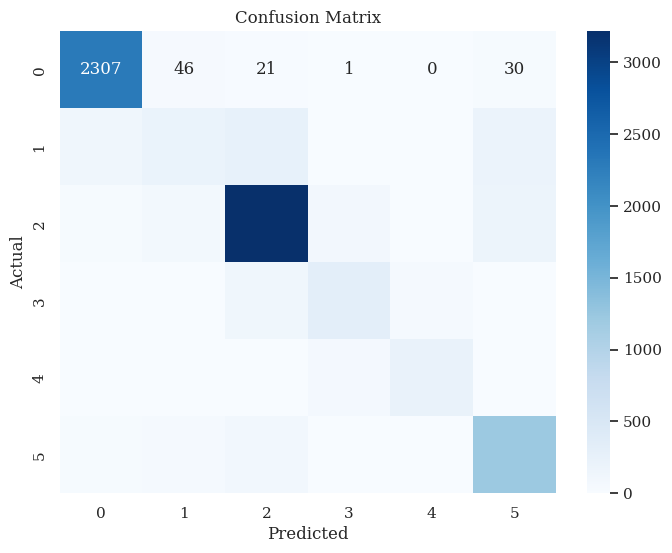

Saved ROC curve as ./output/models/1USleep/1USleep_roc_curve.png


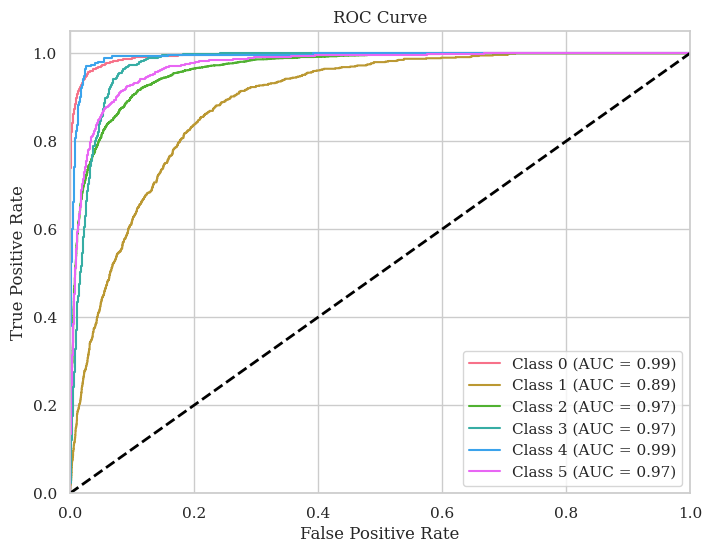

Saved Precision-Recall curve as ./output/models/1USleep/1USleep_pr_curve.png


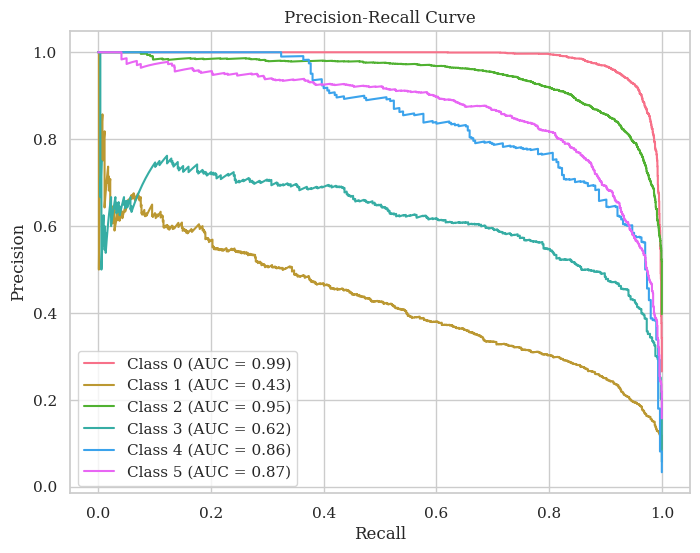

Precision: 0.8155
Recall: 0.8297
F1 Score: 0.8177
Kappa: 0.7653
AUC: 0.9688
Support: {'0': 2405.0, '1': 794.0, '2': 3599.0, '3': 524.0, '4': 305.0, '5': 1428.0}
Confusion Matrix:
[[2307   46   21    1    0   30]
 [ 135  207  263    0    0  189]
 [  34   81 3217   88    0  179]
 [   5    0  138  319   62    0]
 [   1    0    1   69  234    0]
 [  37   58  104    0    0 1229]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2405
           1       0.53      0.26      0.35       794
           2       0.86      0.89      0.88      3599
           3       0.67      0.61      0.64       524
           4       0.79      0.77      0.78       305
           5       0.76      0.86      0.80      1428

    accuracy                           0.83      9055
   macro avg       0.75      0.73      0.73      9055
weighted avg       0.82      0.83      0.82      9055

Saved evaluation results as ./output/models/1USleep/1USl

/home/deepak/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Output shape: torch.Size([32, 6])


/tmp/ipykernel_778648/3720422732.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Saved Confusion Matrix as ./output/models/3cnn-trans-mlp/3cnn-trans-mlp_confusion_matrix.png


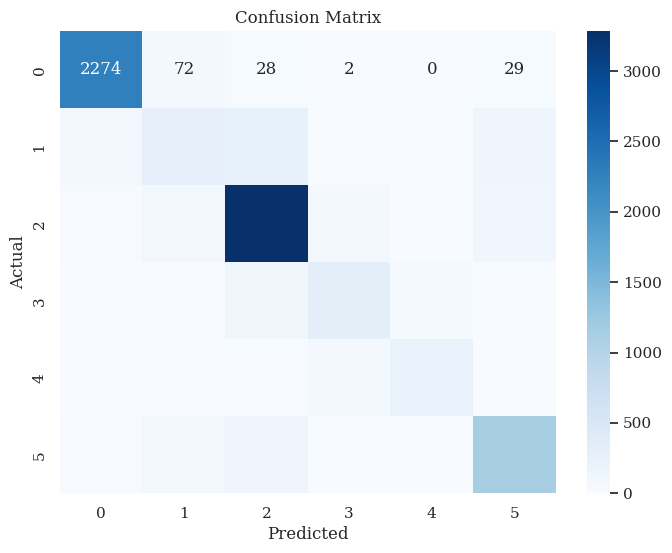

Saved ROC curve as ./output/models/3cnn-trans-mlp/3cnn-trans-mlp_roc_curve.png


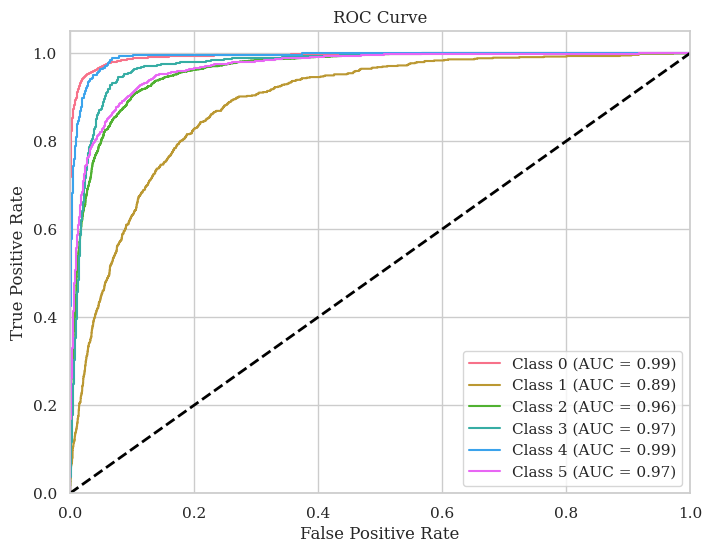

Saved Precision-Recall curve as ./output/models/3cnn-trans-mlp/3cnn-trans-mlp_pr_curve.png


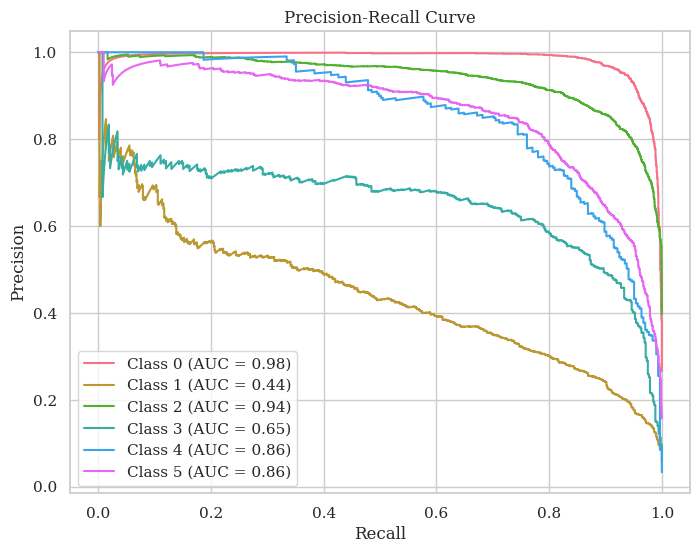

Precision: 0.8206
Recall: 0.8311
F1 Score: 0.8239
Kappa: 0.7669
AUC: 0.9663
Support: {'0': 2405.0, '1': 794.0, '2': 3599.0, '3': 524.0, '4': 305.0, '5': 1428.0}
Confusion Matrix:
[[2274   72   28    2    0   29]
 [ 104  274  263    1    0  152]
 [  20   91 3283   81    2  122]
 [   1    0  138  322   63    0]
 [   1    0    3   66  235    0]
 [  23  105  162    0    0 1138]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      2405
           1       0.51      0.35      0.41       794
           2       0.85      0.91      0.88      3599
           3       0.68      0.61      0.65       524
           4       0.78      0.77      0.78       305
           5       0.79      0.80      0.79      1428

    accuracy                           0.83      9055
   macro avg       0.76      0.73      0.74      9055
weighted avg       0.82      0.83      0.82      9055

Saved evaluation results as ./output/models/3cnn-trans-m

/home/deepak/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:23: UserWarning: SleepStagerChambon2018: 'n_channels' is depreciated. Use 'n_chans' instead.
  warnings.warn(
/home/deepak/miniconda3/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipykernel_778648/3720422732.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no lo

Saved Confusion Matrix as ./output/models/6SleepStagerChambon2018/6SleepStagerChambon2018_confusion_matrix.png


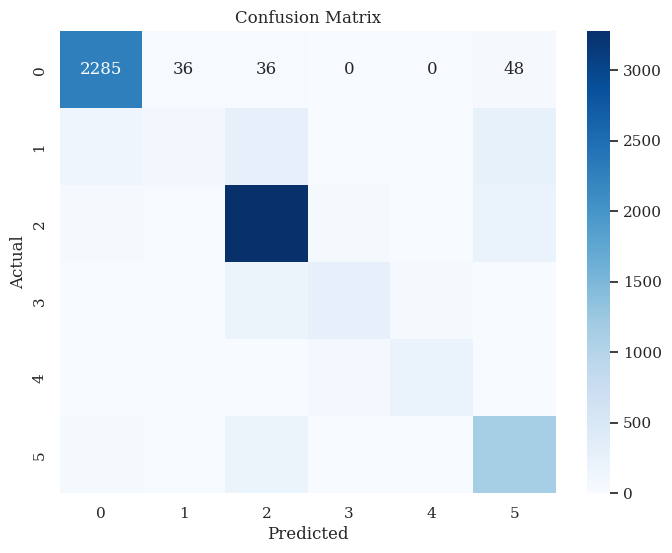

Saved ROC curve as ./output/models/6SleepStagerChambon2018/6SleepStagerChambon2018_roc_curve.png


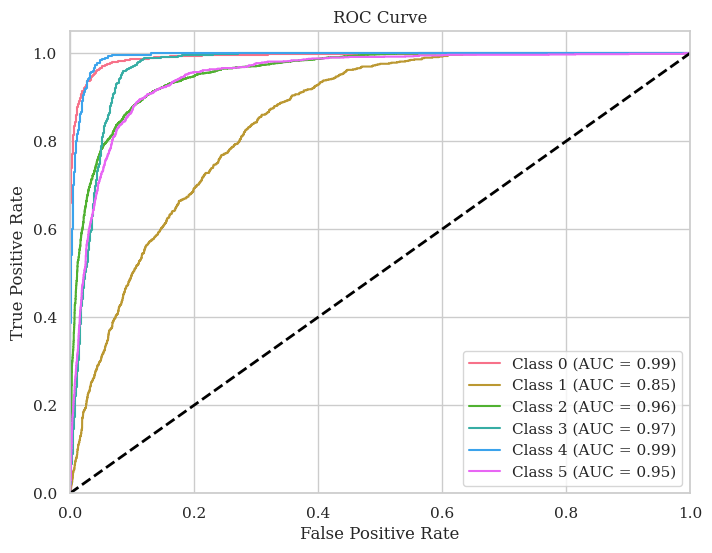

Saved Precision-Recall curve as ./output/models/6SleepStagerChambon2018/6SleepStagerChambon2018_pr_curve.png


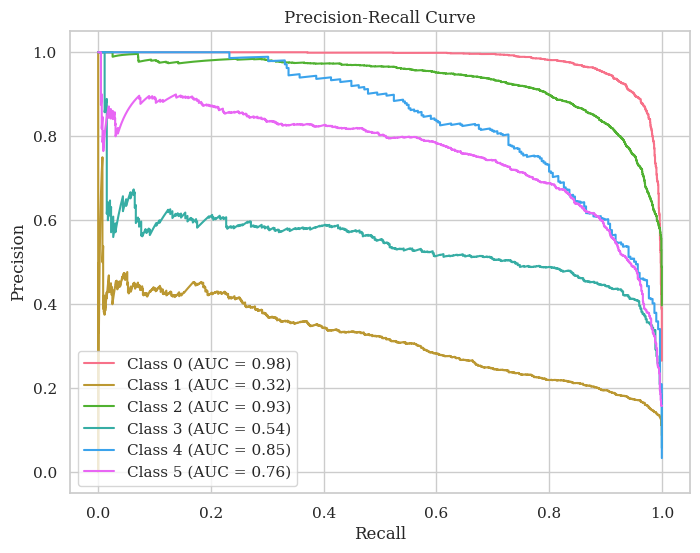

Precision: 0.7842
Recall: 0.8051
F1 Score: 0.7812
Kappa: 0.7279
AUC: 0.9573
Support: {'0': 2405.0, '1': 794.0, '2': 3599.0, '3': 524.0, '4': 305.0, '5': 1428.0}
Confusion Matrix:
[[2285   36   36    0    0   48]
 [ 164   91  280    0    0  259]
 [  41   20 3276   56    1  205]
 [   6    0  180  276   61    1]
 [   4    0    6   80  215    0]
 [  53   30  198    0    0 1147]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      2405
           1       0.51      0.11      0.19       794
           2       0.82      0.91      0.86      3599
           3       0.67      0.53      0.59       524
           4       0.78      0.70      0.74       305
           5       0.69      0.80      0.74      1428

    accuracy                           0.81      9055
   macro avg       0.73      0.67      0.67      9055
weighted avg       0.78      0.81      0.78      9055

Saved evaluation results as ./output/models/6SleepStager

/tmp/ipykernel_778648/3720422732.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Saved Confusion Matrix as ./output/models/2residual/2residual_confusion_matrix.png


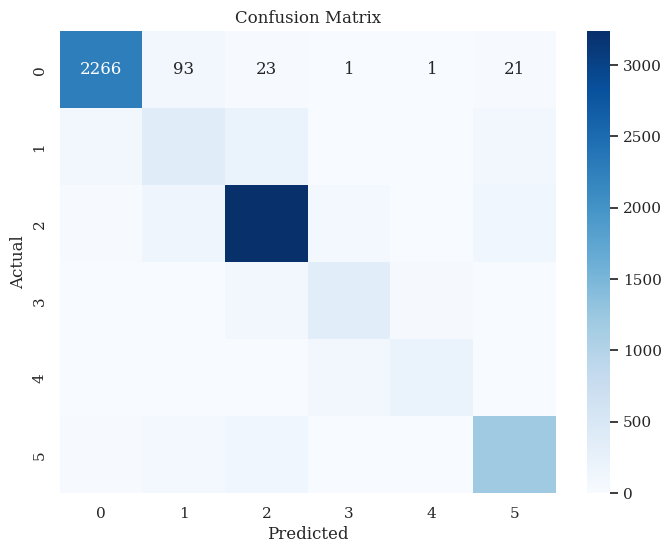

Saved ROC curve as ./output/models/2residual/2residual_roc_curve.png


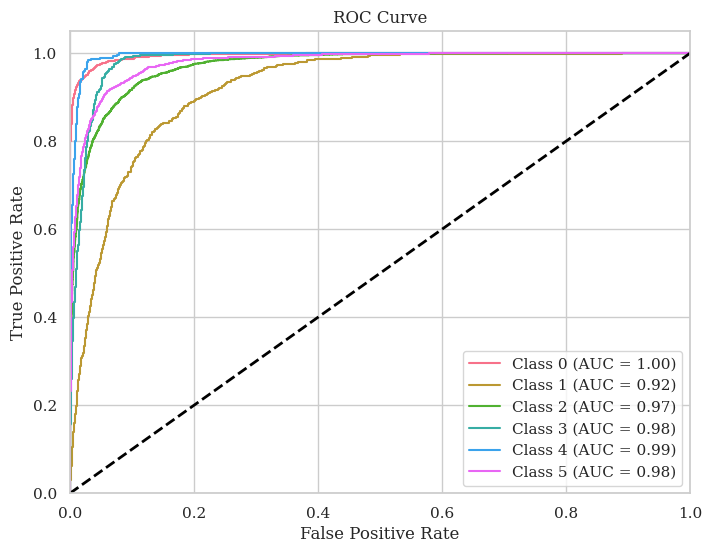

Saved Precision-Recall curve as ./output/models/2residual/2residual_pr_curve.png


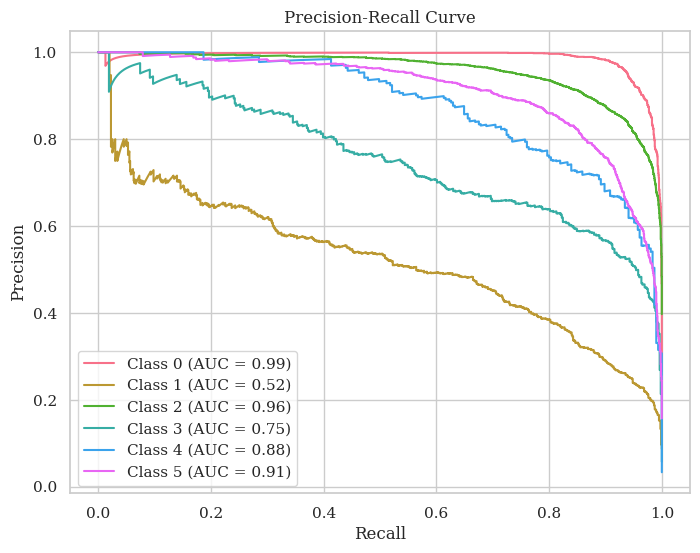

Precision: 0.8415
Recall: 0.8448
F1 Score: 0.8427
Kappa: 0.7876
AUC: 0.9761
Support: {'0': 2405.0, '1': 794.0, '2': 3599.0, '3': 524.0, '4': 305.0, '5': 1428.0}
Confusion Matrix:
[[2266   93   23    1    1   21]
 [  99  373  211    2    0  109]
 [  20  142 3236   84    0  117]
 [   3    1  112  366   42    0]
 [   1    0    1   95  208    0]
 [  25   88  114    0    0 1201]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2405
           1       0.54      0.47      0.50       794
           2       0.88      0.90      0.89      3599
           3       0.67      0.70      0.68       524
           4       0.83      0.68      0.75       305
           5       0.83      0.84      0.84      1428

    accuracy                           0.84      9055
   macro avg       0.78      0.76      0.77      9055
weighted avg       0.84      0.84      0.84      9055

Saved evaluation results as ./output/models/2residual/2r

/home/deepak/miniconda3/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipykernel_778648/3720422732.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f

Saved Confusion Matrix as ./output/models/4winner/4winner_confusion_matrix.png


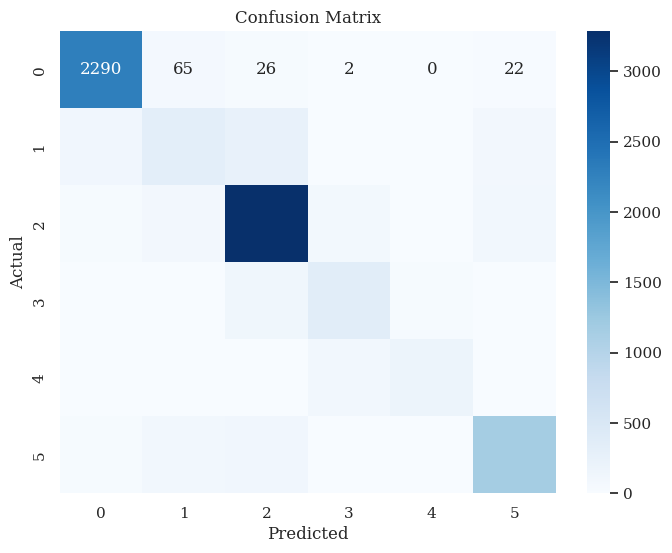

Saved ROC curve as ./output/models/4winner/4winner_roc_curve.png


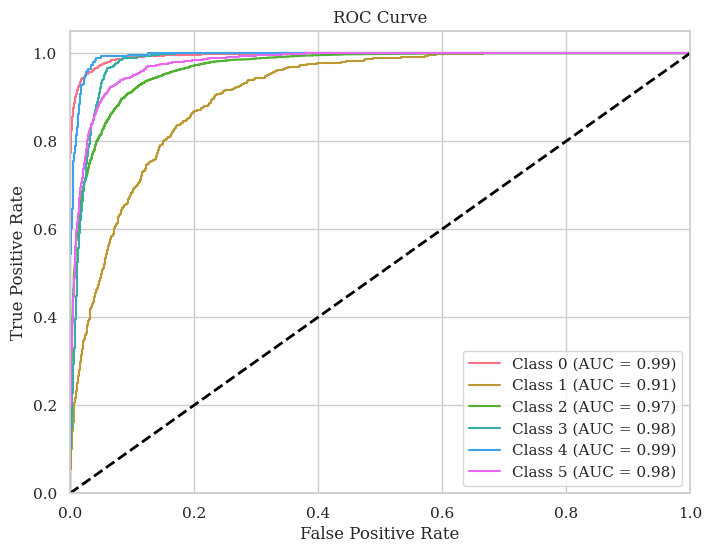

Saved Precision-Recall curve as ./output/models/4winner/4winner_pr_curve.png


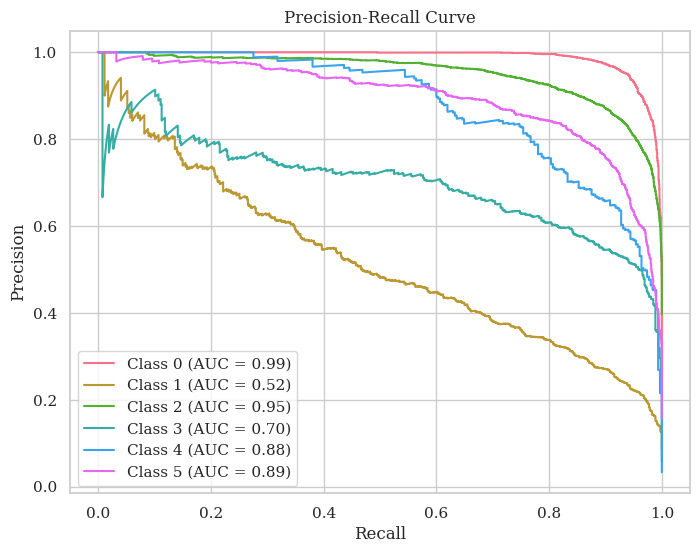

Precision: 0.8336
Recall: 0.8405
F1 Score: 0.8350
Kappa: 0.7801
AUC: 0.9736
Support: {'0': 2405.0, '1': 794.0, '2': 3599.0, '3': 524.0, '4': 305.0, '5': 1428.0}
Confusion Matrix:
[[2290   65   26    2    0   22]
 [ 120  322  254    2    0   96]
 [  28   90 3286   81    0  114]
 [   1    1  131  362   29    0]
 [   1    0    2  111  191    0]
 [  36  104  128    0    0 1160]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2405
           1       0.55      0.41      0.47       794
           2       0.86      0.91      0.88      3599
           3       0.65      0.69      0.67       524
           4       0.87      0.63      0.73       305
           5       0.83      0.81      0.82      1428

    accuracy                           0.84      9055
   macro avg       0.78      0.73      0.75      9055
weighted avg       0.83      0.84      0.83      9055

Saved evaluation results as ./output/models/4winner/4win

/home/deepak/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:23: UserWarning: SleepStagerBlanco2020: 'n_channels' is depreciated. Use 'n_chans' instead.
  warnings.warn(
/home/deepak/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +
/home/deepak/miniconda3/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipykernel_778648/3720422732.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https:

Saved Confusion Matrix as ./output/models/5SleepStagerBlanco2020/5SleepStagerBlanco2020_confusion_matrix.png


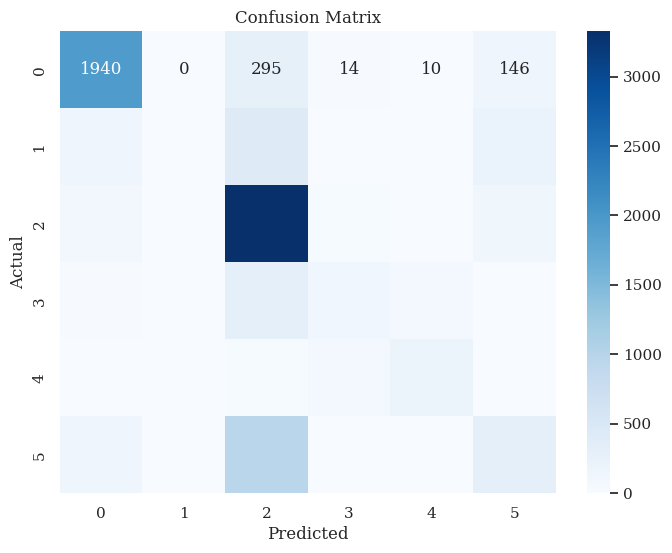

Saved ROC curve as ./output/models/5SleepStagerBlanco2020/5SleepStagerBlanco2020_roc_curve.png


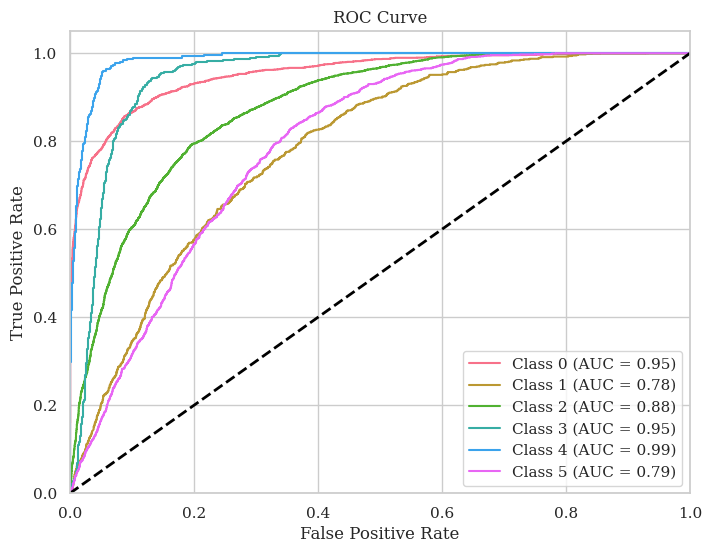

Saved Precision-Recall curve as ./output/models/5SleepStagerBlanco2020/5SleepStagerBlanco2020_pr_curve.png


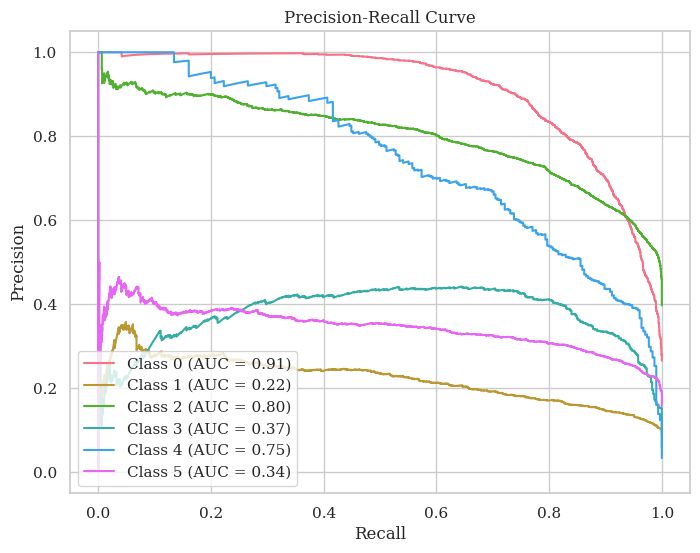

Precision: 0.5781
Recall: 0.6505
F1 Score: 0.5957
Kappa: 0.4848
AUC: 0.8834
Support: {'0': 2405.0, '1': 794.0, '2': 3599.0, '3': 524.0, '4': 305.0, '5': 1428.0}
Confusion Matrix:
[[1940    0  295   14   10  146]
 [ 145    0  428    0    0  221]
 [  99    0 3326   30    8  136]
 [  21    0  317  117   69    0]
 [  10    0   38   71  186    0]
 [ 148    0  959    0    0  321]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      2405
           1       0.00      0.00      0.00       794
           2       0.62      0.92      0.74      3599
           3       0.50      0.22      0.31       524
           4       0.68      0.61      0.64       305
           5       0.39      0.22      0.29      1428

    accuracy                           0.65      9055
   macro avg       0.50      0.46      0.47      9055
weighted avg       0.58      0.65      0.60      9055

Saved evaluation results as ./output/models/5SleepStager

In [2]:
import subprocess
import os
from datetime import datetime
import glob
import torch

# Check if CUDA is available and print whether using CUDA or CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Define paths to scripts
dataloader_script = './dataloader.py'
model_runner_script = './model_runner.py'
evaluator_script = './evaluator.py'

# Log file path
log_dir = './output/'
log_file = os.path.join(log_dir, 'pipeline_log.txt')

# Ensure the log directory exists
os.makedirs(log_dir, exist_ok=True)

# Function to log both to the console and to a file
def log(message):
    print(message)
    with open(log_file, 'a') as f:
        f.write(f"{message}\n")

# Function to run a Python script and log the output
def run_script(script_path, *args):
    command = ['python3', script_path] + list(args)
    try:
        log(f"Running: {' '.join(command)}")
        result = subprocess.run(command, check=True, capture_output=True, text=True)
        log(result.stdout)
    except subprocess.CalledProcessError as e:
        log(f"Error running {script_path}:")
        log(e.stderr)

def main():
    # Start logging
    log(f"\n{'='*40}\nStarting pipeline at {datetime.now()}\n{'='*40}\n")

    # Step 1: Run dataloader.py to load data
    log("Running dataloader.py...")
    run_script(dataloader_script)

    # Step 2: Iterate over each model in the modelpy/ directory
    model_files = glob.glob('./modelpy/*.py')  # List all .py files in modelpy/

    for model_py_path in model_files:
        # Extract the base model name (without .py extension)
        model_name = os.path.basename(model_py_path).replace('.py', '')

        log(f"\nRunning model: {model_name}")

        # Step 3: Run model_runner.py with model.py as argument
        log(f"Running model_runner.py with argument: {model_py_path}")
        run_script(model_runner_script, model_py_path)
        
        # Path for the corresponding .pt file (adjust this according to how your models are saved)
        model_pt_path = f'./output/models/{model_name}/{model_name}_final_model.pt'
# Students/Susmit_23CS60R75/model_final/FINAL_run/ipynbRun/output/models/SleepStagerBlanco2020/SleepStagerBlanco2020_final_model.pt
        

        # Step 4: Run evaluator.py with model.pt and model.py as arguments
        log(f"Running evaluator{model_name}")
        evalfun(model_py_path, model_pt_path)
        # run_script(evaluator_script, model_pt_path, model_py_path)

    log(f"\nPipeline completed at {datetime.now()}\n{'='*40}\n")

if __name__ == '__main__':
    main()
